In [4]:
# ---------------------------------------------------
# 1. Import Required Libraries
# ---------------------------------------------------
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import joblib
import warnings

warnings.filterwarnings("ignore")

In [5]:
# ---------------------------------------------------
# 2. Load Dataset
# ---------------------------------------------------
data_file = "CO2_Emissions.csv"
try:
    df = pd.read_csv(data_file)
    print("Dataset loaded successfully!")
except:
    raise FileNotFoundError("CSV file not found. Please place it in the same folder.")

print("\nDataset Preview:\n", df.head())

Dataset loaded successfully!

Dataset Preview:
     Make       Model Vehicle Class  Engine Size(L)  Cylinders Transmission  \
0  ACURA         ILX       COMPACT             2.0          4          AS5   
1  ACURA         ILX       COMPACT             2.4          4           M6   
2  ACURA  ILX HYBRID       COMPACT             1.5          4          AV7   
3  ACURA     MDX 4WD   SUV - SMALL             3.5          6          AS6   
4  ACURA     RDX AWD   SUV - SMALL             3.5          6          AS6   

  Fuel Type  Fuel Consumption City (L/100 km)  \
0         Z                               9.9   
1         Z                              11.2   
2         Z                               6.0   
3         Z                              12.7   
4         Z                              12.1   

   Fuel Consumption Hwy (L/100 km)  Fuel Consumption Comb (L/100 km)  \
0                              6.7                               8.5   
1                              7.7          

In [6]:
# ---------------------------------------------------
# 3. Select Useful Columns
# ---------------------------------------------------
# Column detection helper
def find_col(possible):
    for name in possible:
        matches = [col for col in df.columns if name.lower() in col.lower()]
        if matches:
            return matches[0]
    return None

col_engine = find_col(["engine", "engine size"])
col_cyl = find_col(["cyl"])
col_comb = find_col(["comb", "fuelconsumption_comb"])
col_city = find_col(["city"])
col_hwy = find_col(["hwy", "highway"])
col_fuel = find_col(["fueltype", "fuel type"])
col_co2 = find_col(["co2"])

needed = [col_engine, col_cyl, col_comb, col_fuel, col_co2]
if col_co2 is None:
    raise Exception("CO2 column missing. Check CSV column names.")

In [7]:
# Build working dataset
selected_cols = []
for c in [col_engine, col_cyl, col_comb, col_city, col_hwy, col_fuel, col_co2]:
    if c is not None:
        selected_cols.append(c)

data = df[selected_cols].copy()
data.columns = ["EngineSize", "Cylinders", "FuelCombined", "FuelCity",
                "FuelHighway", "FuelType", "CO2"][:len(selected_cols)]

print("\nColumns After Selection:", data.columns.tolist())


Columns After Selection: ['EngineSize', 'Cylinders', 'FuelCombined', 'FuelCity', 'FuelHighway', 'FuelType', 'CO2']


In [8]:

# ---------------------------------------------------
# 4. Clean Data
# ---------------------------------------------------
data = data.drop_duplicates().dropna().reset_index(drop=True)

# If "FuelCombined" missing, compute average
if "FuelCombined" not in data.columns and "FuelCity" in data.columns:
    data["FuelCombined"] = (data["FuelCity"] + data["FuelHighway"]) / 2

In [9]:
# ---------------------------------------------------
# 5. Encode Categorical Data
# ---------------------------------------------------
if "FuelType" in data.columns:
    data = pd.get_dummies(data, columns=["FuelType"], drop_first=True)

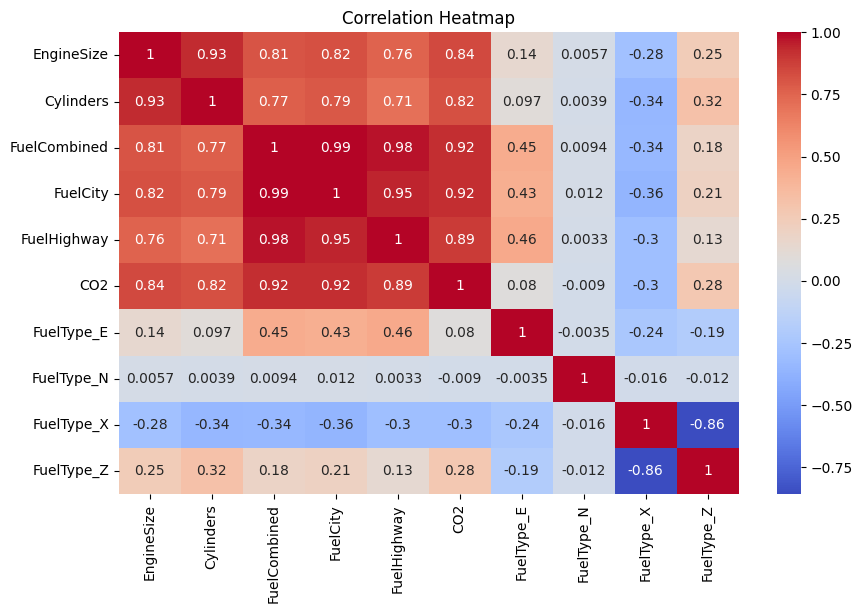

In [10]:
# ---------------------------------------------------
# 6. Correlation Heatmap
# ---------------------------------------------------
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

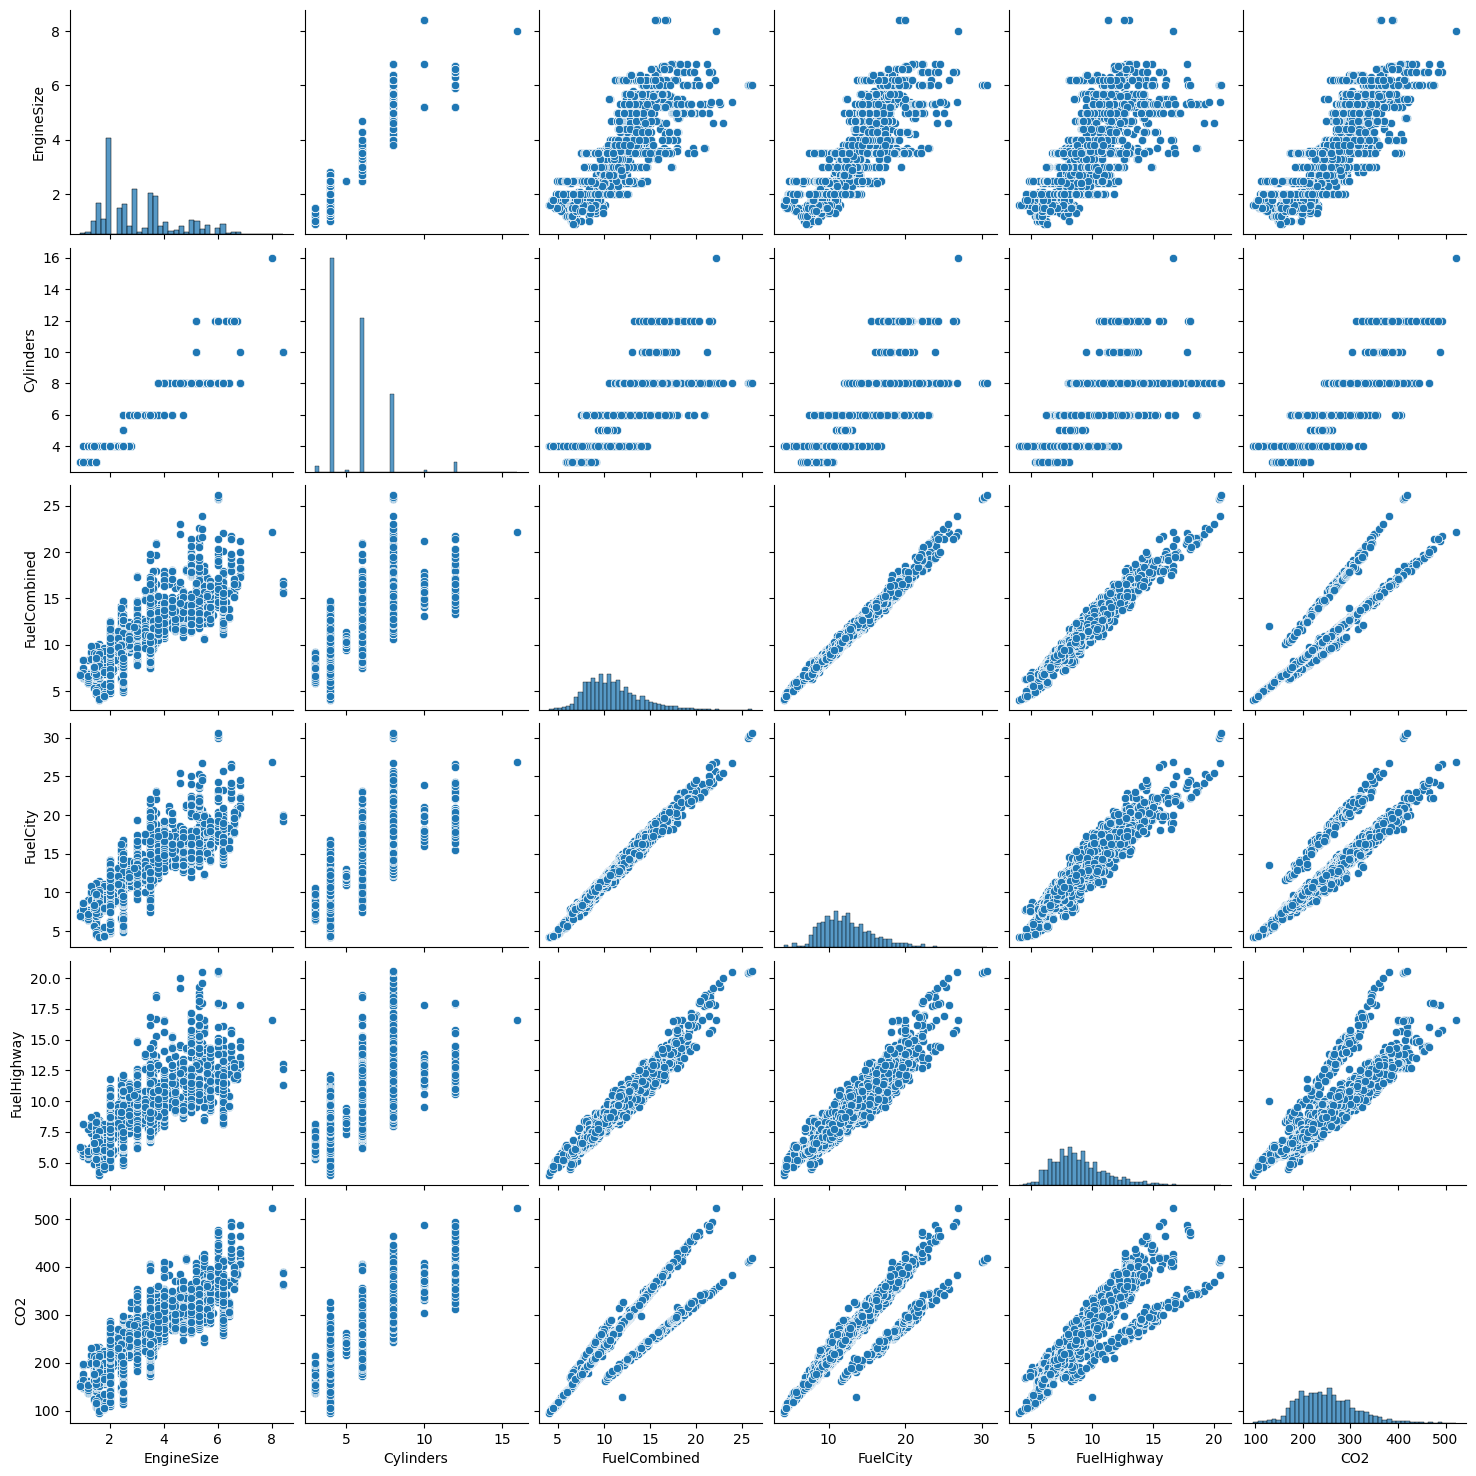

In [12]:
# ---------------------------------------------------
# 7. Pairplot
# ---------------------------------------------------
sns.pairplot(data[["EngineSize", "Cylinders", "FuelCombined", "FuelCity", "FuelHighway", "CO2"]])
plt.show()

In [14]:
# ---------------------------------------------------
# 8. Split Features & Target
# ---------------------------------------------------
target = data["CO2"]
features = data.drop("CO2", axis=1)

In [15]:
# Scale numeric data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [16]:
# ---------------------------------------------------
# 9. Train–Test Split
# ---------------------------------------------------
x_train, x_test, y_train, y_test = train_test_split(
    scaled_features, target, test_size=0.2, random_state=7
)

In [17]:
# ---------------------------------------------------
# 10. Model Training Function
# ---------------------------------------------------
def train_and_score(model, xtr, ytr, xte, yte):
    model.fit(xtr, ytr)
    preds = model.predict(xte)
    results = {
        "R2": r2_score(yte, preds),
        "MAE": mean_absolute_error(yte, preds),
        "RMSE": np.sqrt(mean_squared_error(yte, preds)),
    }
    return results, preds

In [18]:
# ---------------------------------------------------
# 11. Train Different Models
# ---------------------------------------------------
model1 = LinearRegression()
model2 = DecisionTreeRegressor(max_depth=8, random_state=7)
model3 = RandomForestRegressor(n_estimators=160, max_depth=None,
                               min_samples_split=3, random_state=7)

In [19]:
# Evaluate
res1, p1 = train_and_score(model1, x_train, y_train, x_test, y_test)
res2, p2 = train_and_score(model2, x_train, y_train, x_test, y_test)
res3, p3 = train_and_score(model3, x_train, y_train, x_test, y_test)

print("\nLinear Regression:", res1)
print("Decision Tree:", res2)
print("Random Forest:", res3)


Linear Regression: {'R2': 0.986910671315295, 'MAE': 3.2613514854819163, 'RMSE': np.float64(6.71246685521934)}
Decision Tree: {'R2': 0.9911090183027085, 'MAE': 3.0508980100163456, 'RMSE': np.float64(5.532205775019883)}
Random Forest: {'R2': 0.9926807480627505, 'MAE': 2.9663381731292264, 'RMSE': np.float64(5.019457897055375)}


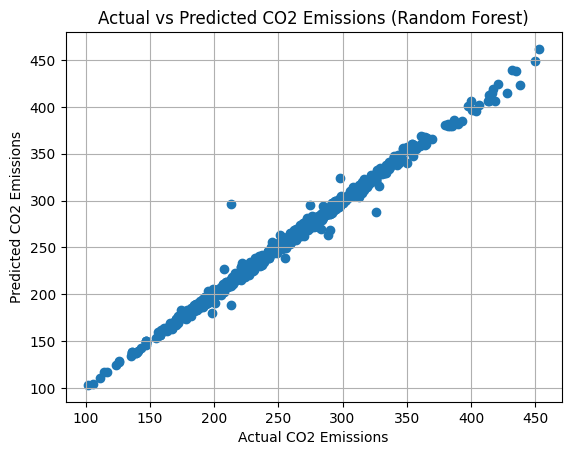

In [20]:
# ---------------------------------------------------
# 12. Actual vs Predicted (Random Forest)
# ---------------------------------------------------
plt.scatter(y_test, p3)
plt.xlabel("Actual CO2 Emissions")
plt.ylabel("Predicted CO2 Emissions")
plt.title("Actual vs Predicted CO2 Emissions (Random Forest)")
plt.grid(True)
plt.show()

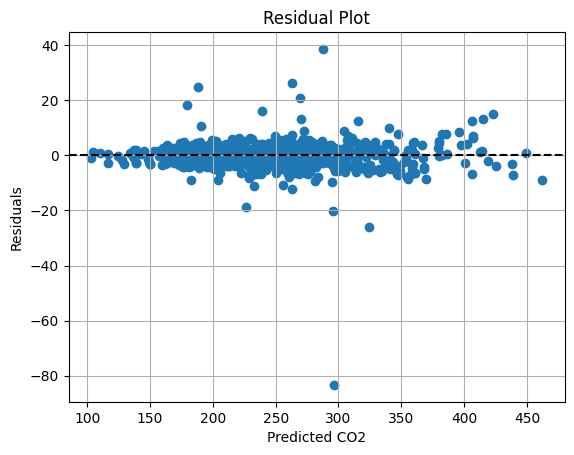

In [21]:
# ---------------------------------------------------
# 13. Residual Plot
# ---------------------------------------------------
residuals = y_test - p3

plt.scatter(p3, residuals)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Predicted CO2")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.grid(True)
plt.show()

In [22]:
# ---------------------------------------------------
# 14. Model Comparison
# ---------------------------------------------------
compare = pd.DataFrame({
    "Model": ["LinearRegression", "DecisionTree", "RandomForest"],
    "R2 Score": [res1["R2"], res2["R2"], res3["R2"]],
    "RMSE": [res1["RMSE"], res2["RMSE"], res3["RMSE"]]
})

print("\nModel Performance Comparison:\n", compare)


Model Performance Comparison:
               Model  R2 Score      RMSE
0  LinearRegression  0.986911  6.712467
1      DecisionTree  0.991109  5.532206
2      RandomForest  0.992681  5.019458


In [23]:
# ---------------------------------------------------
# 15. Save Best Model
# ---------------------------------------------------
joblib.dump(model3, "CO2_RF_Model.joblib")
joblib.dump(scaler, "CO2_scaler.joblib")
print("\nRandom Forest model saved as CO2_RF_Model.joblib")


Random Forest model saved as CO2_RF_Model.joblib


In [24]:
# ---------------------------------------------------
# 16. Make a Sample Prediction
# ---------------------------------------------------
example = pd.DataFrame([{
    "EngineSize": 2.0,
    "Cylinders": 4,
    "FuelCombined": 8.5,
    "FuelCity": 9.0,
    "FuelHighway": 7.5,
    # If there are one-hot columns -> set them to 0 manually
}])

In [25]:
# Add missing one-hot columns if any
for col in features.columns:
    if col not in example.columns:
        example[col] = 0

example = example[features.columns]
scaled_example = scaler.transform(example)

loaded = joblib.load("CO2_RF_Model.joblib")
output = loaded.predict(scaled_example)

print("\nSample Vehicle CO2 Prediction:", round(output[0], 2), "g/km")


Sample Vehicle CO2 Prediction: 206.35 g/km
